# Import Data

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler

In [6]:
data = pd.read_csv('1000mlRetail.csv')

# Preliminary Data Exploration

In [7]:
data.shape

(51290, 24)

In [8]:
data.head(2)

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,City,State,...,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Cost,Order Priority
0,32298,CA-2016-124891,2016-07-31,2016-07-31,Same Day,RH-19495,Rick Hansen,Consumer,New York City,New York,...,TEC-AC-10003033,Technology,Accessories,Plantronics CS510 - Over-the-Head monaural Wir...,2309.650,7,0.0,762.1845,933.57,Critical
1,26341,IN-2017-77878,2017-02-05,2017-02-07,Second Class,JR-16210,Justin Ritter,Corporate,Wollongong,New South Wales,...,FUR-CH-10003950,Furniture,Chairs,"Novimex Executive Leather Armchair, Black",3709.395,9,0.1,-288.7650,923.63,Critical


In [9]:
data.dtypes

Row ID              int64
Order ID           object
Order Date         object
Ship Date          object
Ship Mode          object
Customer ID        object
Customer Name      object
Segment            object
City               object
State              object
Country            object
Postal Code       float64
Market             object
Region             object
Product ID         object
Category           object
Sub-Category       object
Product Name       object
Sales             float64
Quantity            int64
Discount          float64
Profit            float64
Shipping Cost     float64
Order Priority     object
dtype: object

In [10]:
data.isnull().sum() 

Row ID                0
Order ID              0
Order Date            0
Ship Date             0
Ship Mode             0
Customer ID           0
Customer Name         0
Segment               0
City                  0
State                 0
Country               0
Postal Code       41296
Market                0
Region                0
Product ID            0
Category              0
Sub-Category          0
Product Name          0
Sales                 0
Quantity              0
Discount              0
Profit                0
Shipping Cost         0
Order Priority        0
dtype: int64

Only PostalCodes have Null values. Therefore we can continue our data exploration, as the data seems clean on first glance.

In [11]:
print(f'Column: Unique Values')
print('---------------------')

for name in data.columns:
  print(f'{name}: {len(data[name].unique())}')

Column: Unique Values
---------------------
Row ID: 51290
Order ID: 25035
Order Date: 1430
Ship Date: 1460
Ship Mode: 4
Customer ID: 1590
Customer Name: 795
Segment: 3
City: 3636
State: 1094
Country: 147
Postal Code: 632
Market: 7
Region: 13
Product ID: 10292
Category: 3
Sub-Category: 17
Product Name: 3788
Sales: 22995
Quantity: 14
Discount: 27
Profit: 24575
Shipping Cost: 10037
Order Priority: 4


A couple columns have only few unique entries. We can filter these out for the later use of dummy variables, choosing the upper boundary of 17 as cutoff, as Discount is a numerical variable.

In [12]:
for name in data.columns:
    if len(data[name].unique()) <= 17:
        print(f'{name}: {data[name].unique()}')

Ship Mode: ['Same Day' 'Second Class' 'First Class' 'Standard Class']
Segment: ['Consumer' 'Corporate' 'Home Office']
Market: ['US' 'APAC' 'EU' 'Africa' 'EMEA' 'LATAM' 'Canada']
Region: ['East' 'Oceania' 'Central' 'Africa' 'West' 'South' 'Central Asia' 'EMEA'
 'North Asia' 'North' 'Caribbean' 'Southeast Asia' 'Canada']
Category: ['Technology' 'Furniture' 'Office Supplies']
Sub-Category: ['Accessories' 'Chairs' 'Phones' 'Copiers' 'Tables' 'Binders' 'Supplies'
 'Appliances' 'Machines' 'Bookcases' 'Storage' 'Furnishings' 'Art' 'Paper'
 'Envelopes' 'Fasteners' 'Labels']
Quantity: [ 7  9  5  8  4  6 13 12 14 10  2 11  3  1]
Order Priority: ['Critical' 'Medium' 'High' 'Low']


Quantity is a numerical variables, so it won't be considered with the other categorical Variables.

In [13]:
data['Order Date'] = pd.to_datetime(data['Order Date'])
data['Ship Date'] = pd.to_datetime(data['Ship Date'])
data['month'] = [x.month-1 for x in data['Order Date']]

Dates as datetime objects as to see if the shipping date has an affect on sales

In [14]:
col_to_categorize = []
for name in data.drop(['Quantity','month'],1).columns:
  if len(data[name].unique()) <= 17:
    col_to_categorize.append(name)

col_for_model = col_to_categorize   

Filter all columns that contain 17 or less unique values as categories

In [15]:
data[col_for_model].head(2)

,Ship Mode,Segment,Market,Region,Category,Sub-Category,Order Priority
0,Same Day,Consumer,US,East,Technology,Accessories,Critical
1,Second Class,Corporate,APAC,Oceania,Furniture,Chairs,Critical


In [16]:
data.corr()['Sales']

Row ID          -0.043889
Postal Code     -0.023854
Sales            1.000000
Quantity         0.313577
Discount        -0.086722
Profit           0.484918
Shipping Cost    0.768073
month            0.001815
Name: Sales, dtype: float64

We drop Row ID, Postal Code, Discount and month as a variable for our regression model because the correlation is below 0.2 as a threshold

# Outliers

In order to deal with outliers we remove 1% of the data set that contains the largest/smallest values depending on the distribution

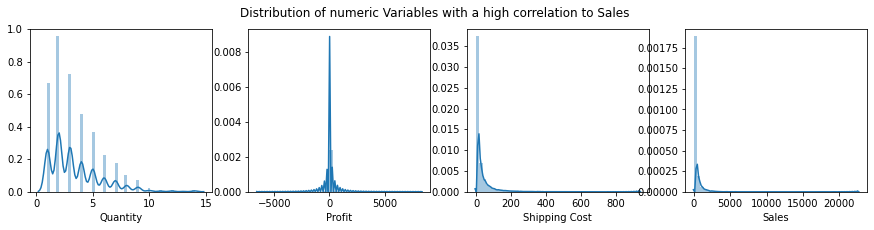

In [17]:
fig, axs = plt.subplots(1,4, figsize=(15,3))

for column, ax in zip(['Quantity','Profit','Shipping Cost','Sales'], axs.flatten()[:4]):
  sns.distplot(data[column],ax=ax)

plt.suptitle('Distribution of numeric Variables with a high correlation to Sales')
plt.show()

Shipping Cost and Sales are both one sided distributions, so we remove the top 1%. For Profit we remove the top and bottom 0.5%. For this we use quantiles.

In [18]:
q_SC = data['Shipping Cost'].quantile(0.99)
q_S = data['Sales'].quantile(0.99)
q_P1 = data['Profit'].quantile(0.005)
q_P2 = data['Profit'].quantile(0.995)

In [19]:
data = data[data['Shipping Cost']<q_SC][data['Sales']<q_S][data['Profit']>q_P1][data['Profit']<q_P2].reset_index()

/home/steve/Desktop/Unit1_Project2/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/home/steve/Desktop/Unit1_Project2/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
/home/steve/Desktop/Unit1_Project2/venv/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


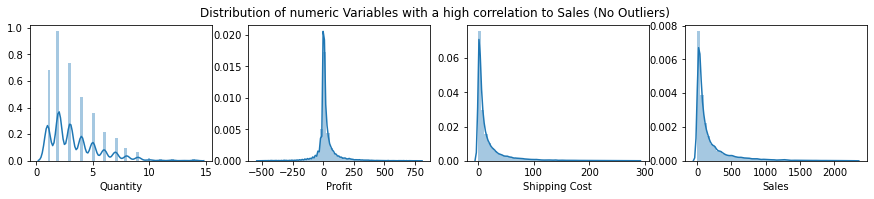

In [20]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1,4, figsize=(15,2.5))

sns.distplot(data['Quantity'],ax=ax1)

sns.distplot(data['Profit'],ax=ax2)

sns.distplot(data['Shipping Cost'],ax=ax3)

sns.distplot(data['Sales'],ax=ax4)

plt.suptitle('Distribution of numeric Variables with a high correlation to Sales (No Outliers)')
plt.show()

After removing the outliers we see that the distributions haven't changed, they are just less spread out.

# Transformations

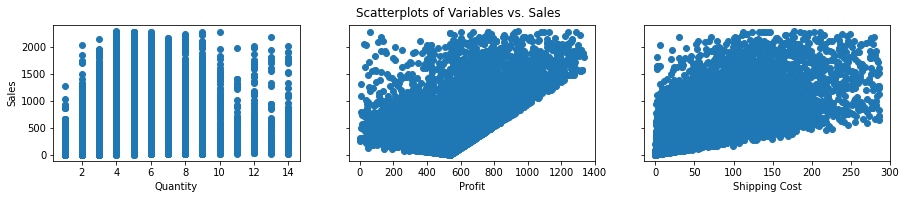

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,2.5),sharey=True)

y_values = data['Sales']

ax1.scatter(data['Quantity'], y_values)

ax2.scatter( data['Profit'] + abs(min(data['Profit'])) +1 , y_values)

ax3.scatter(data['Shipping Cost'], y_values)

ax1.set_ylabel('Sales')
ax1.set_xlabel('Quantity')
ax2.set_xlabel('Profit')
ax3.set_xlabel('Shipping Cost')

plt.suptitle('Scatterplots of Variables vs. Sales')
plt.show()

The scatter plots already follow a fairly wide but noticable linear relationship. For exploration sake we will look at log-linear and log-log transformations as well, to see if they give a more distinct linear relationship.

In [22]:
def log_base(x, base):
    return np.log(x)/np.log(base)

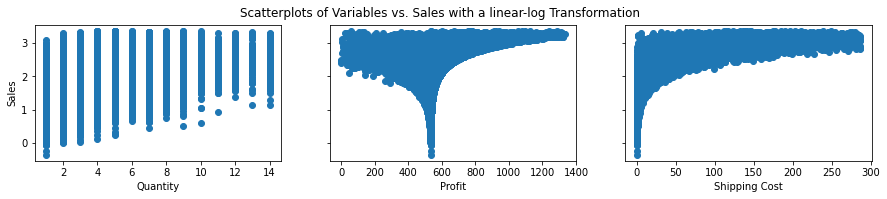

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,2.5),sharey=True)

y_values = log_base(data['Sales'],10)

ax1.scatter( data['Quantity'] , y_values )

ax2.scatter( data['Profit'] + abs(min(data['Profit'])) +1, y_values )

ax3.scatter( data['Shipping Cost'] , y_values )

ax1.set_ylabel('Sales')
ax1.set_xlabel('Quantity')
ax2.set_xlabel('Profit')
ax3.set_xlabel('Shipping Cost')

plt.suptitle('Scatterplots of Variables vs. Sales with a linear-log Transformation')
plt.show()

The log-linear transformation doesn't provide distinctly better relationships, therefore will not be used.

/home/steve/Desktop/Unit1_Project2/venv/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


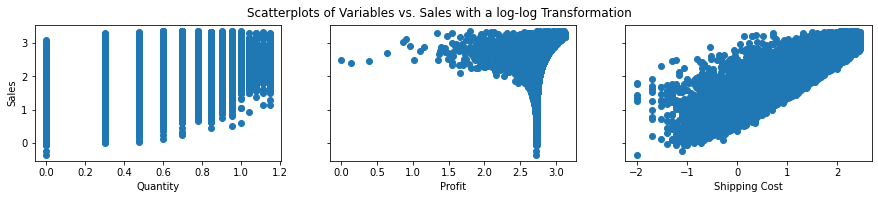

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(15,2.5),sharey=True)

y_values = log_base(data['Sales'],10)

ax1.scatter( log_base(data['Quantity'],10) , y_values )

ax2.scatter( log_base(data['Profit'] + abs(min(data['Profit']))+1 ,10) , y_values )

ax3.scatter( log_base(data['Shipping Cost'],10) , y_values )

ax1.set_ylabel('Sales')
ax1.set_xlabel('Quantity')
ax2.set_xlabel('Profit')
ax3.set_xlabel('Shipping Cost')

plt.suptitle('Scatterplots of Variables vs. Sales with a log-log Transformation')
plt.show()

The log-log transformation doesn't provide distinctly better relationships, therefore will not be used.

# OLS Regression 

### (R2 0.713/root MSE 165.045)

We start with a simple OLS model to predict sales based only on the numerical variables with a correlation higher than 0.2. 

Adding a constant, doing a train test split and then run the model

In [25]:
#set variables
x = data[['Quantity','Profit','Shipping Cost']]
y = data['Sales']

#add constant
x = sm.add_constant(x)

#test train split
x_train, x_test, y_train, y_test = train_test_split(
                                          x, y, test_size = 0.2, random_state = 42
                                        )

# run model
lin_model = sm.OLS(y_train, x_train).fit()

lin_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.713
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                 3.335e+04
Date:                Thu, 03 Sep 2020   Prob (F-statistic):               0.00
Time:                        14:52:34   Log-Likelihood:            -2.6231e+05
No. Observations:               40200   AIC:                         5.246e+05
Df Residuals:                   40196   BIC:                         5.247e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            13.0304      1.519      8.579      0.000      10.053      16.007
Quantity         12.7817      0.382     33.440      0.000      12.033      13.531
Profit            0.6332      0.009     67.656      0.000       0.615       0.652
Shipping Cost     6.2321      0.026    236.606      0.000       6.180       6.284
==============================================================================
Omnibus:                    21103.356   Durbin-Watson:                   2.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           484482.168
Skew:                           2.038   Prob(JB):                         0.00
Kurtosis:                      19.511   Cond. No.                         192.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Printing the R2 scores and MSEs for both the training and test set

In [26]:
#R2 scores
print(f'Train score: {r2_score(y_train,lin_model.predict(x_train)):.3f}')
print(f'Test score: {r2_score(y_test,lin_model.predict(x_test)):.3f}')
#Root MSE Values
print(f'Train root mse: {mean_squared_error(y_train, lin_model.predict(x_train))**0.5:.3f}')
print(f'Test root mse: {mean_squared_error(y_test, lin_model.predict(x_test))**0.5:.3f}')

Train score: 0.713
Test score: 0.699
Train root mse: 165.045
Test root mse: 165.913


# OLS with categorical Variables 

### (R2 0.788/root MSE 142.092)

Next we add all the categorical variables that have 17 or less unique values.

In [27]:
#set variables
x = data[['Quantity','Profit','Shipping Cost']]
y = data['Sales']

In [28]:
dummy_variables = data[col_for_model]
dummy_variables.head(2)

,Ship Mode,Segment,Market,Region,Category,Sub-Category,Order Priority
0,First Class,Corporate,APAC,Central Asia,Technology,Machines,High
1,Same Day,Corporate,APAC,Central Asia,Technology,Phones,Critical


In order to deal with categorical data, we have to create dummy variables (values of 0 or 1) for each categorical variable value.

In [29]:
dummy = pd.get_dummies(dummy_variables, drop_first=True)
dummy.head(2)

,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,Segment_Corporate,Segment_Home Office,Market_Africa,Market_Canada,Market_EMEA,Market_EU,Market_LATAM,...,Sub-Category_Labels,Sub-Category_Machines,Sub-Category_Paper,Sub-Category_Phones,Sub-Category_Storage,Sub-Category_Supplies,Sub-Category_Tables,Order Priority_High,Order Priority_Low,Order Priority_Medium
0,0,0,0,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


Adding the categorical dummies to the previous numerical variables to run the model on.

In [30]:
x = pd.concat([x,dummy],axis=1)
x.head(2)

,Quantity,Profit,Shipping Cost,Ship Mode_Same Day,Ship Mode_Second Class,Ship Mode_Standard Class,Segment_Corporate,Segment_Home Office,Market_Africa,Market_Canada,...,Sub-Category_Labels,Sub-Category_Machines,Sub-Category_Paper,Sub-Category_Phones,Sub-Category_Storage,Sub-Category_Supplies,Sub-Category_Tables,Order Priority_High,Order Priority_Low,Order Priority_Medium
0,6,482.22,286.74,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,0,0
1,5,260.40,286.67,1,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [31]:
#test train split
x_train, x_test, y_train, y_test = train_test_split(
                                          x, y, test_size = 0.2, random_state = 42
                                        )

#add constant to train and test x
x_train = sm.add_constant(x_train)
x_test = sm.add_constant(x_test)

# run model
lin_model = sm.OLS(y_train, x_train).fit()

lin_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.788
Model:                            OLS   Adj. R-squared:                  0.787
Method:                 Least Squares   F-statistic:                     3631.
Date:                Thu, 03 Sep 2020   Prob (F-statistic):               0.00
Time:                        14:52:35   Log-Likelihood:            -2.5629e+05
No. Observations:               40200   AIC:                         5.127e+05
Df Residuals:                   40158   BIC:                         5.130e+05
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                      -45.6945      2.867    -15.939      0.000     -51.314     -40.075
Quantity                    16.9637      0.350     48.527      0.000      16.279      17.649
Profit                       0.6184      0.008     74.533      0.000       0.602       0.635
Shipping Cost                5.5165      0.028    199.105      0.000       5.462       5.571
Ship Mode_Same Day           3.8600      3.620      1.066      0.286      -3.234      10.954
Ship Mode_Second Class      32.4843      2.478     13.108      0.000      27.627      37.342
Ship Mode_Standard Class    52.6086      2.289     22.983      0.000      48.122      57.095
Segment_Corporate           -0.4141      1.625     -0.255      0.799      -3.599       2.771
Segment_Home Office          0.8080      1.939      0.417      0.677      -2.992       4.608
Market_Africa              -10.0472      2.341     -4.292      0.000     -14.636      -5.459
Market_Canada               -2.4650      3.903     -0.632      0.528     -10.115       5.185
Market_EMEA                 -3.9139      1.187     -3.298      0.001      -6.240      -1.588
Market_EU                    7.1467      1.893      3.775      0.000       3.436      10.857
Market_LATAM               -20.4332      1.809    -11.298      0.000     -23.978     -16.888
Market_US                  -20.7706      2.062    -10.072      0.000     -24.813     -16.729
Region_Canada               -2.4650      3.903     -0.632      0.528     -10.115       5.185
Region_Caribbean           -12.3355      3.817     -3.232      0.001     -19.817      -4.854
Region_Central              -2.8330      1.728     -1.640      0.101      -6.220       0.554
Region_Central Asia          1.8101      3.310      0.547      0.584      -4.677       8.297
Region_EMEA                 -3.9139      1.187     -3.298      0.001      -6.240      -1.588
Region_East                 -5.5536      3.303     -1.681      0.093     -12.028       0.921
Region_North                -4.3017      2.472     -1.740      0.082      -9.147       0.544
Region_North Asia           -5.3272      3.118     -1.708      0.088     -11.439       0.784
Region_Oceania               5.4252      2.597      2.089      0.037       0.335      10.515
Region_South                -3.9467      1.968     -2.005      0.045      -7.804      -0.089
Region_Southeast Asia        2.8805      2.753      1.046      0.295      -2.515       8.276
Region_West                 -5.0866      3.168     -1.606      0.108     -11.296       1.123
Category_Office Supplies   -95.7026      1.470    -65.100      0.000     -98.584     -92.821
Category_Technology        -77.3447      2.768    -27.947      0.000     -82.769     -71.920
Sub-Category_Appliances    108.0866      3.726     29.011      0.000     100.784     115.389
Sub-Category_A

Printing the R2 scores and MSEs for both the training and test set

In [32]:
#R2 scores
print(f'Train score: {r2_score(y_train,lin_model.predict(x_train)):.3f}')
print(f'Test score: {r2_score(y_test,lin_model.predict(x_test)):.3f}')
#Root MSE Values
print(f'Train root mse: {mean_squared_error(y_train, lin_model.predict(x_train))**0.5:.3f}')
print(f'Test root mse: {mean_squared_error(y_test, lin_model.predict(x_test))**0.5:.3f}')

Train score: 0.788
Test score: 0.777
Train root mse: 142.092
Test root mse: 142.869


We see an increase in R2 and decrease in MSE compared to the Regression without the categorical values. That's good!

* We keep the categorical variables `'Category'`, `'Subcategory'` and `'Order Priority'`, because the other variables and their dummies have p values above 0.05.
* For modelling purposes we also drop `'Sub-Category'`, as this and `'Category'` are most likely collinear and `'Category'` has less dummies

# OLS with selected categorical Variables 

### (R2 0.759/root MSE 151.447)

Running the model with only the selected categorical and the numerical Variables.

In [33]:
#set variables
x = data[['Quantity','Profit','Shipping Cost']]
y = data['Sales']

#add categorical Variables with dummies
dummy_variables = data[['Category','Order Priority']]
dummy = pd.get_dummies(dummy_variables, drop_first=True)
x = pd.concat([x,dummy],axis=1)

#test train split
x_train, x_test, y_train, y_test = train_test_split(
                                          x, y, test_size = 0.2, random_state = 42
                                        )

#add constant to train and test x
x_train = sm.add_constant(x_train)
x_test = sm.add_constant(x_test)

# run model
lin_model = sm.OLS(y_train, x_train).fit()

lin_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                 1.579e+04
Date:                Thu, 03 Sep 2020   Prob (F-statistic):               0.00
Time:                        14:52:35   Log-Likelihood:            -2.5885e+05
No. Observations:               40200   AIC:                         5.177e+05
Df Residuals:                   40191   BIC:                         5.178e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                      -83.7371      3.569    -23.462      0.000     -90.732     -76.742
Quantity                    13.1347      0.354     37.079      0.000      12.440      13.829
Profit                       0.5799      0.009     66.927      0.000       0.563       0.597
Shipping Cost                6.2131      0.027    231.767      0.000       6.161       6.266
Category_Office Supplies   -79.7931      2.080    -38.369      0.000     -83.869     -75.717
Category_Technology         -2.5485      2.453     -1.039      0.299      -7.356       2.259
Order Priority_High        112.2427      3.131     35.844      0.000     106.105     118.380
Order Priority_Low         133.5904      4.446     30.047      0.000     124.876     142.305
Order Priority_Medium      185.4304      3.040     60.987      0.000     179.471     191.390
==============================================================================
Omnibus:                    22620.825   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           591557.164
Skew:                           2.206   Prob(JB):                         0.00
Kurtosis:                      21.268   Cond. No.                         836.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [34]:
#R2 scores
print(f'Train score: {r2_score(y_train,lin_model.predict(x_train)):.3f}')
print(f'Test score: {r2_score(y_test,lin_model.predict(x_test)):.3f}')
#Root MSE Values
print(f'Train root mse: {mean_squared_error(y_train, lin_model.predict(x_train))**0.5:.3f}')
print(f'Test root mse: {mean_squared_error(y_test, lin_model.predict(x_test))**0.5:.3f}')

Train score: 0.759
Test score: 0.748
Train root mse: 151.447
Test root mse: 152.016


In [35]:
print(lin_model.predict(x_test).mean())
print(data['Sales'].mean())

204.54315437018175
202.91418981213926


We see a slight decrease in R2 and increase in MSE. However the vastly reduced amount of variables justifies this drop in accuracy. The metrics are still better than the simple OLS model from the beginning. 

The means of the targets and predicted targets are very close to each other.

In [36]:
def show_values_on_bars(axs, h_v="v", space=0.4):
    def _show_on_single_plot(ax):
        if h_v == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height()
                value = float(p.get_height().round(1))
                ax.text(_x, _y, value, ha="center")
        elif h_v == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height()
                value = float(p.get_width().round(1))
                ax.text(_x, _y, value, ha="left", va="bottom")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

We plot the Values of the coefficients for each Variable

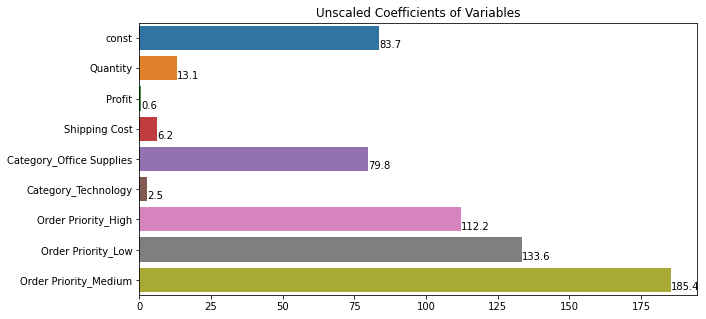

In [37]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.barplot(lin_model.params.abs(), lin_model.params.index,ax=ax)
show_values_on_bars(ax, "h", 0)

plt.title('Unscaled Coefficients of Variables')
plt.show()

It appears that Order Priority has large impact on Sales. However We have to scale the variables first in order to get insight about the impact of each Variable

# OLS with selected categorical Variables and Scaling 

### (R2 0.759/MSE 0.491)

In order to scale variables to make them comparable we subtract the mean from each value and divide by the standard deviation. This is done by the StandardScaler() function and has to be performed separate for each Split set.

In [38]:
#set variables
x = data[['Quantity','Profit','Shipping Cost']]
y = data['Sales']

#add categorical Variables with dummies
dummy_variables = data[['Category','Order Priority']]
dummy = pd.get_dummies(dummy_variables, drop_first=True)
x = pd.concat([x,dummy],axis=1)

#test train split
x_train, x_test, y_train, y_test = train_test_split(
                                          x, y, test_size = 0.2, random_state = 42
                                        )


# create a standard scaler for each variable and variable partition
for col in x_train.columns:
    ss_x_train = StandardScaler()
    x_train[col] = ss_x_train.fit_transform(np.array(x_train[col]).reshape(-1,1))

    ss_x_test = StandardScaler()
    x_test[col] = ss_x_test.fit_transform(np.array(x_test[col]).reshape(-1,1))

# fit the fit_transform train set
ss_y_train = StandardScaler()
y_train = ss_y_train.fit_transform(np.array(y_train).reshape(-1,1))

#fit the fit_transform test set
ss_y_test = StandardScaler()
y_test = ss_y_test.fit_transform(np.array(y_test).reshape(-1,1))

#add constant to train and test x
x_train = sm.add_constant(x_train)
x_test = sm.add_constant(x_test)

# run model
lin_model = sm.OLS(y_train, x_train).fit()

lin_model.summary()

/home/steve/Desktop/Unit1_Project2/venv/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/steve/Desktop/Unit1_Project2/venv/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/steve/Desktop/Unit1_Project2/venv/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value in

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.759
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                 1.579e+04
Date:                Thu, 03 Sep 2020   Prob (F-statistic):               0.00
Time:                        14:52:36   Log-Likelihood:                -28467.
No. Observations:               40200   AIC:                         5.695e+04
Df Residuals:                   40191   BIC:                         5.703e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                     1.713e-17      0.002   6.99e-15      1.000      -0.005       0.005
Quantity                     0.0949      0.003     37.079      0.000       0.090       0.100
Profit                       0.1822      0.003     66.927      0.000       0.177       0.188
Shipping Cost                0.7109      0.003    231.767      0.000       0.705       0.717
Category_Office Supplies    -0.1257      0.003    -38.369      0.000      -0.132      -0.119
Category_Technology         -0.0033      0.003     -1.039      0.299      -0.009       0.003
Order Priority_High          0.1673      0.005     35.844      0.000       0.158       0.176
Order Priority_Low           0.0931      0.003     30.047      0.000       0.087       0.099
Order Priority_Medium        0.2973      0.005     60.987      0.000       0.288       0.307
==============================================================================
Omnibus:                    22620.825   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           591557.164
Skew:                           2.206   Prob(JB):                         0.00
Kurtosis:                      21.268   Cond. No.                         3.99
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [39]:
#R2 scores
print(f'Train score: {r2_score(y_train,lin_model.predict(x_train)):.3f}')
print(f'Test score: {r2_score(y_test,lin_model.predict(x_test)):.3f}')
#Root MSE Values
print(f'Train root mse: {mean_squared_error(y_train, lin_model.predict(x_train))**0.5:.3f}')
print(f'Test root mse: {mean_squared_error(y_test, lin_model.predict(x_test))**0.5:.3f}')

Train score: 0.759
Test score: 0.748
Train root mse: 0.491
Test root mse: 0.502


We see that the R2 score hasnt changed when scaling, the Root MSE however has due to the scaling.

In [40]:
y_prediction_test = lin_model.predict(x_test)
y_pred = ss_y_test.inverse_transform(y_prediction_test)
print(y_pred.mean())
print(data['Sales'].mean())

202.4462891482587
202.91418981213926


The means of the targets and predicted targets are very close to each other.

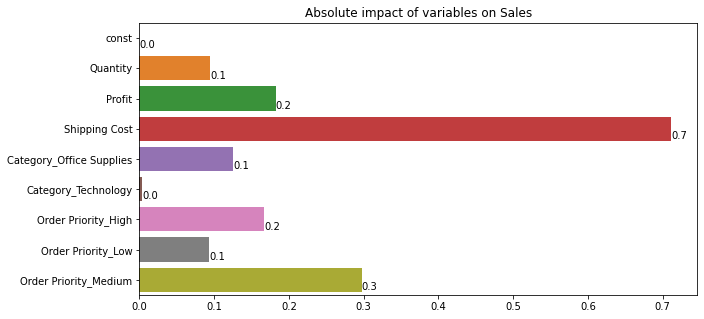

In [41]:
fig, ax = plt.subplots(1,1, figsize=(10,5))
sns.barplot(lin_model.params.abs(), lin_model.params.index,ax=ax)
show_values_on_bars(ax, "h", 0)

plt.title('Absolute impact of variables on Sales')
plt.show()

Due to scaling we can now see the impact of each variable on sales. Shipping cost has by far the highest impact, which makes sense because the correlation between the two was above 0.7.

In [42]:
formula = 'Sales = '

for i in range(len(lin_model.params)-1):
    formula = formula + str(lin_model.params[i+1].round(3)) + '*(' + str(lin_model.params.index[i+1]) + ')'
 
    if i+2 <= len(lin_model.params)-1:
        if lin_model.params[i+2] >= 0:
            formula = formula + '+'

print(formula)

Sales = 0.095*(Quantity)+0.182*(Profit)+0.711*(Shipping Cost)-0.126*(Category_Office Supplies)-0.003*(Category_Technology)+0.167*(Order Priority_High)+0.093*(Order Priority_Low)+0.297*(Order Priority_Medium)


This is the final formula of our model. However all variables are scaled and the resulting predictions need to be rescaled as well.

$Sales = 0.095*(Quantity)+0.182*(Profit)+0.711*(Shipping Cost)-0.126*(Category_Office Supplies)$
$-0.003*(Category_Technology)+0.167*(Order Priority_High)$
$+0.093*(Order Priority_Low)+0.297*(Order Priority_Medium)$

# Not Used

/home/steve/Desktop/Unit1_Project2/venv/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/steve/Desktop/Unit1_Project2/venv/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


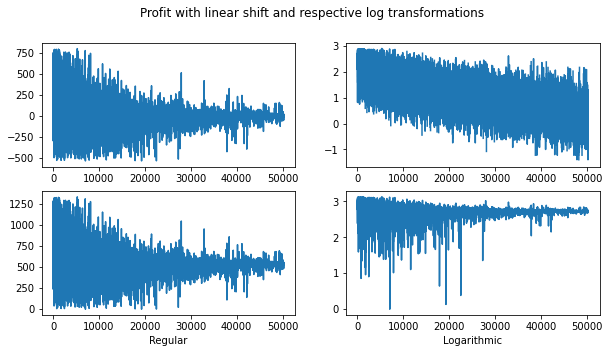

In [43]:
plot = 'Profit'

fig, axs = plt.subplots(2,2, figsize=(10,5))

axs.flatten()[0].plot(data[plot])

axs.flatten()[1].plot(log_base( data[plot] ,10))

axs.flatten()[2].plot(data[plot] + abs(min(data[plot]) +1) )

axs.flatten()[3].plot(log_base( data[plot] + abs(min(data[plot])) +1 ,10))

axs.flatten()[2].set_xlabel('Regular')
axs.flatten()[3].set_xlabel('Logarithmic')

fig.suptitle(f'{plot} with linear shift and respective log transformations')

plt.show()

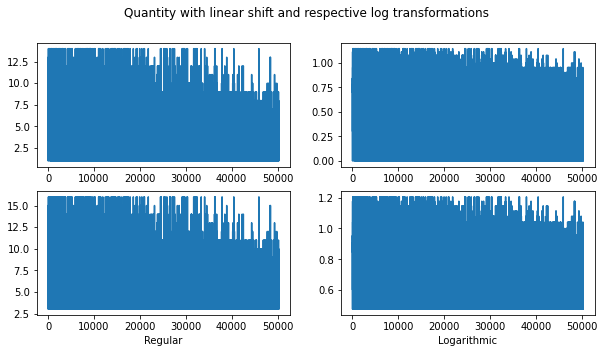

In [44]:
plot = 'Quantity'

fig, axs = plt.subplots(2,2, figsize=(10,5))

axs.flatten()[0].plot(data[plot])

axs.flatten()[1].plot(log_base( data[plot] ,10))

axs.flatten()[2].plot(data[plot] + abs(min(data[plot]) +1) )

axs.flatten()[3].plot(log_base( data[plot] + abs(min(data[plot])) +1 ,10))

axs.flatten()[2].set_xlabel('Regular')
axs.flatten()[3].set_xlabel('Logarithmic')

fig.suptitle(f'{plot} with linear shift and respective log transformations')

plt.show()

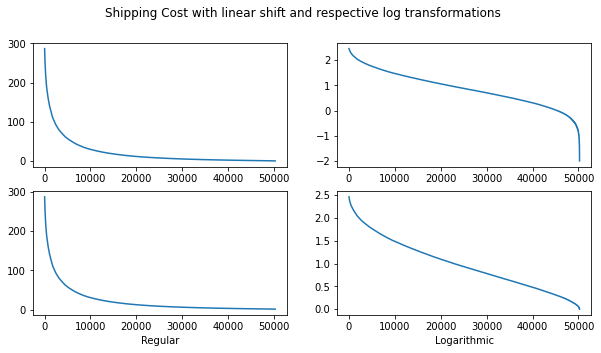

In [45]:
plot = 'Shipping Cost'

fig, axs = plt.subplots(2,2, figsize=(10,5))

axs.flatten()[0].plot(data[plot])

axs.flatten()[1].plot(log_base( data[plot] ,10))

axs.flatten()[2].plot(data[plot] + abs(min(data[plot]) +1) )

axs.flatten()[3].plot(log_base( data[plot] + abs(min(data[plot])) +1 ,10))

axs.flatten()[2].set_xlabel('Regular')
axs.flatten()[3].set_xlabel('Logarithmic')

fig.suptitle(f'{plot} with linear shift and respective log transformations')

plt.show()